<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/fine_tuning_sl/experiments/notebook_sl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

### Download Dataset

In [2]:
!git clone https://github.com/sam-single/realwaste.git

Cloning into 'realwaste'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4782 (delta 4), reused 8 (delta 1), pack-reused 4764 (from 1)
Receiving objects: 100% (4782/4782), 655.92 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4754/4754), done.


### Dataset Class

In [3]:
class RealWasteDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')): # Add more image extensions if needed
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = read_image(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Visualize Data

In [4]:
from torchvision import datasets, transforms, models

image_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float), # Convert image to float,
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = '/content/realwaste/RealWaste'
realwaste_dataset = RealWasteDataset(dataset_path,image_transform)

### Split Dataset

In [7]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


def split_dataset(
    dataset: Dataset,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float
):
    # Get the labels for stratification
    all_labels = np.array(realwaste_dataset.labels)

    # Perform stratified split for train and the rest (val + test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_indices, rest_indices = next(sss.split(np.zeros(len(all_labels)), all_labels))

    # Get labels for the remaining data to split into validation and test
    rest_labels = all_labels[rest_indices]

    # Perform stratified split for validation and test
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    val_indices, test_indices = next(sss_val_test.split(np.zeros(len(rest_labels)), rest_labels))

    # Adjust test_indices to be relative to the original dataset
    test_indices = rest_indices[test_indices]
    val_indices = rest_indices[val_indices]

    # Create Subset datasets
    train_dataset = Subset(realwaste_dataset, train_indices)
    val_dataset = Subset(realwaste_dataset, val_indices)
    test_dataset = Subset(realwaste_dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(
    realwaste_dataset, 0.7, 0.15, 0.15)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3326
Validation set size: 713
Test set size: 713


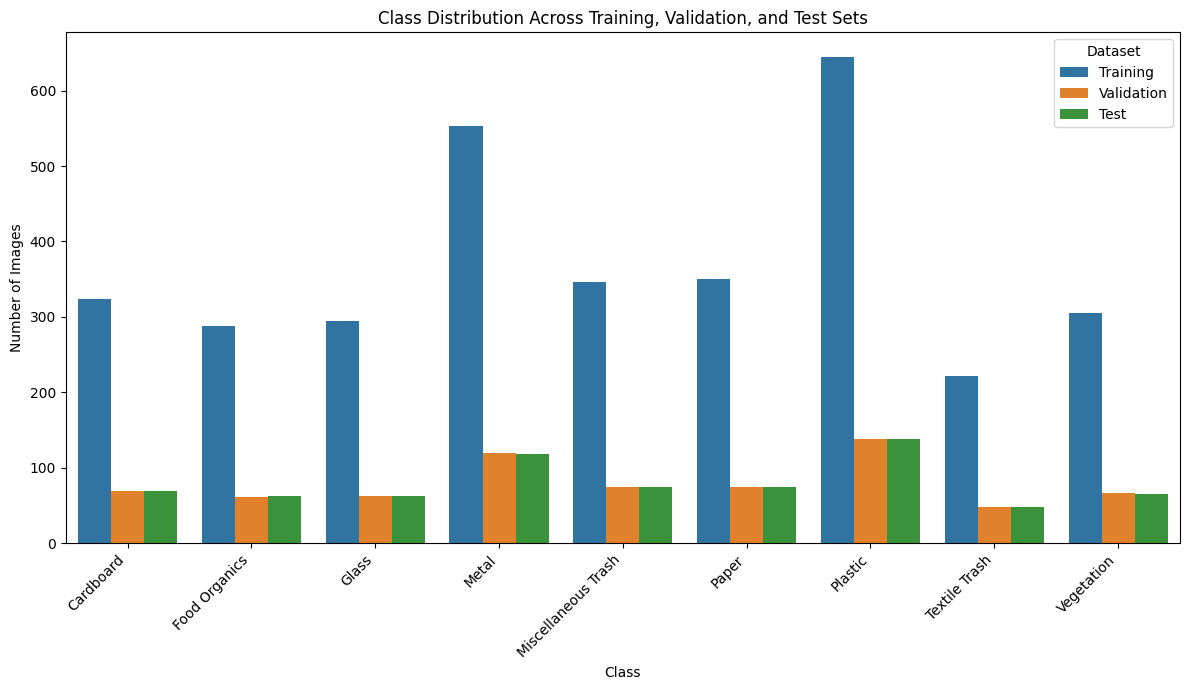

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


#for visualisation
def get_class_counts_df(dataset, dataset_name, classes):
    labels = [realwaste_dataset.labels[i] for i in dataset.indices]
    class_counts = np.bincount(labels, minlength=len(classes))
    df = pd.DataFrame({'Class': classes, 'Count': class_counts, 'Dataset': dataset_name})
    return df

# Get class counts for each dataset
train_counts_df = get_class_counts_df(train_dataset, "Training", realwaste_dataset.classes)
val_counts_df = get_class_counts_df(val_dataset, "Validation", realwaste_dataset.classes)
test_counts_df = get_class_counts_df(test_dataset, "Test", realwaste_dataset.classes)

# Concatenate the dataframes
all_counts_df = pd.concat([train_counts_df, val_counts_df, test_counts_df])

# Plot the combined chart
plt.figure(figsize=(12, 7))
sns.barplot(data=all_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution Across Training, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

def load_data(training_set, validation_set, test_set, batch_size):

    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



    return training_loader, validation_loader, test_loader


training_loader, validation_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset, 32 )


In [13]:
import torch
import torch.nn as nn

class CnnWasteClassifier(nn.Module):
    def __init__(self):
        super(CnnWasteClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 96, 3)
        self.bn3 = nn.BatchNorm2d(96)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(96 * 31 * 31 , 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.bn4((self.fc1(x)))))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_model = CnnWasteClassifier()


In [14]:
def train_dataset(model, training_loader, validation_loader, optimizer, loss_function, epochs):
  train_losses, validation_loss_list =[], [] # Renamed validation_loss to validation_loss_list for clarity
  training_accuracies, validation_accuracies = [], []

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)


  for epoch in range(epochs):

    # training loop
    model.train()
    training_running_loss = 0
    correct, total = 0, 0

    for i, data in enumerate(training_loader):
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      # set the optimizer value to zero
      optimizer.zero_grad()

      output = model(images)
      loss = loss_function(output, labels)
      loss.backward()
      optimizer.step()

      training_running_loss += loss.item()
      # calculate accuracy
      _, predicted = torch.max(output, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = training_running_loss / len(training_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    training_accuracies.append(train_acc)


    # validation loop
    model.eval()
    running_loss_validation = 0
    val_correct, val_total = 0, 0

    with torch.no_grad():
      for i, data in enumerate(validation_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # set the optimizer value to zero (Not strictly necessary in no_grad, but harmless)
        optimizer.zero_grad()

        output = model(images)
        loss = loss_function(output, labels)
        running_loss_validation += loss.item()

        _, predicted = torch.max(output, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()


      validation_loss = running_loss_validation / len(validation_loader) # FIXED:
      validation_acc = 100 * val_correct / val_total
      validation_loss_list.append(validation_loss)
      validation_accuracies.append(validation_acc)

    # Optional: Print epoch results
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.2f}%")

  # Return metrics if needed
  return train_losses, training_accuracies, validation_loss_list, validation_accuracies

learning_rate = 0.0001
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
train_dataset(cnn_model, training_loader, validation_loader, optimizer, criterion, epochs)

Epoch 1/15 | Train Loss: 1.8634, Train Acc: 43.63% | Val Loss: 1.6089, Val Acc: 54.84%
Epoch 2/15 | Train Loss: 1.4441, Train Acc: 58.93% | Val Loss: 1.3492, Val Acc: 59.19%
Epoch 3/15 | Train Loss: 1.1582, Train Acc: 67.17% | Val Loss: 1.1541, Val Acc: 66.90%
Epoch 4/15 | Train Loss: 0.8938, Train Acc: 76.67% | Val Loss: 1.1085, Val Acc: 67.04%
Epoch 5/15 | Train Loss: 0.6668, Train Acc: 84.34% | Val Loss: 1.0582, Val Acc: 67.46%
Epoch 6/15 | Train Loss: 0.4329, Train Acc: 92.99% | Val Loss: 1.1170, Val Acc: 64.10%
Epoch 7/15 | Train Loss: 0.2816, Train Acc: 96.24% | Val Loss: 1.0572, Val Acc: 63.96%
Epoch 8/15 | Train Loss: 0.1763, Train Acc: 98.56% | Val Loss: 0.9790, Val Acc: 67.18%
Epoch 9/15 | Train Loss: 0.1106, Train Acc: 99.67% | Val Loss: 0.9251, Val Acc: 67.74%
Epoch 10/15 | Train Loss: 0.0686, Train Acc: 99.79% | Val Loss: 0.9848, Val Acc: 69.57%
Epoch 11/15 | Train Loss: 0.0522, Train Acc: 99.97% | Val Loss: 0.9542, Val Acc: 69.42%
Epoch 12/15 | Train Loss: 0.0391, Train A

([1.8633948942789664,
  1.444087335696587,
  1.1582031032213798,
  0.8938144405300801,
  0.6668242731919656,
  0.43290904278938586,
  0.28162053513985413,
  0.17625684599177197,
  0.11062804351632412,
  0.06861277748472415,
  0.05215652446405819,
  0.03911941923881666,
  0.029454563341390055,
  0.024592301378456447,
  0.02036245813808189],
 [43.62597714972941,
  58.929645219482865,
  67.1677690920024,
  76.66867107636801,
  84.3355381840048,
  92.99458809380637,
  96.24173180998196,
  98.55682501503307,
  99.66927239927841,
  99.78953698135899,
  99.96993385447986,
  100.0,
  100.0,
  99.96993385447986,
  99.96993385447986],
 [1.6089406946431035,
  1.3491819734158723,
  1.1540828528611555,
  1.1085068065187205,
  1.0581543160521465,
  1.117038325123165,
  1.0572176135104636,
  0.9789812409359476,
  0.9251028066096099,
  0.9847827216853267,
  0.9541673167892124,
  0.9525961642679961,
  0.9454623771750409,
  0.9871906975041265,
  1.4962452805560569],
 [54.83870967741935,
  59.18653576437